### **Univariate statistical analysis**

Author: Filip Ottosson, 
faot@ssi.dk

We will use univariate statistical methods, such as ANOVA, to investigate whether there are differences in the levels of individual features between different time points in the dataset.

**Data**

The files used in this tutorial are part of an interlab comparison study, where different laboratories around the world analysed same environmental samples on their respective LC-MS/MS equipments. To simulate algal bloom, standardized algae extracts (A) in marine dissovled organic matter (M) at different concentrations were prepared (450 (A45M); 150 (A15M); and 50 (A5M) ppm A). Samples were then shipped to different laboratories for untargeted LC-MS/MS metabolomics analysis.

**Task**


*   Are metabolite levels dependent on the diltuion?
*   How does the affected metabolite change throughout the dilution series?
*   How large are the differences? 



##**Install and import R packages**


In [185]:
install.packages("ggsci")
install.packages("matrixStats")
install.packages("ggrepel")
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [186]:
suppressPackageStartupMessages({
library(tidyverse)
library(ggsci)
library(matrixStats)
library(ggrepel)
})

##**Import metabolite feature table and meta data**

In [187]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/processed/Imputed_QuantTable_filled_with_1267_CutOff_Used_0.3.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Metabolomics_SummerSchool_2022/main/data/dom/metadata_lab15.txt'

In [188]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [189]:
dim(ft)
dim(md)

[1] 2395   12

[1] 13  4

In [190]:
head(ft, n=2)

,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A45M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_A5M_Pos_MS2_rep3.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep1.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep2.mzML,DOM_Interlab-LCMS_Lab15_M_Pos_MS2_rep3.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3488_151.112_9.684,92659.64,107936.6,90535.35,84885.34,95607.41,92654.02,88818.61,91449.84,72474.91,72892.23,86713.87,123999.6
3026_153.091_8.525,226318.05,234986.2,238839.39,139233.22,145115.98,171750.98,194286.90,189326.75,215591.77,201655.44,221566.31,235400.4


In [191]:
head(md, n=2)

,filename,ATTRIBUTE_Sample,ATTRIBUTE_Sample_Type,ATTRIBUTE_Time-Point
,<chr>,<chr>,<chr>,<int>
1,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep1.mzML,A15M,Sample,15
2,DOM_Interlab-LCMS_Lab15_A15M_Pos_MS2_rep2.mzML,A15M,Sample,15


In [192]:
# name rows in metadata after filenames
rownames(md) <- md$filename

In [193]:
# how many files in the metadata are also present in the feature table
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    1    12 

In [194]:
# which file names in the metadata are not in the feature table?
setdiff(rownames(md),colnames(ft))

[1] "DOM_Interlab-LCMS_Lab15_PPL_Pos_MS2.mzML"

In [195]:
md <- md[rownames(md) %in% colnames(ft),]

In [196]:
dim(md)

[1] 12  4

In [197]:
# transpose ft
ft <- t(ft)

In [198]:
dim(ft)

[1]   12 2395

In [199]:
identical(rownames(ft),rownames(md))
# put the rows in the feature table and metadata in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] TRUE

[1] TRUE

Too many missing values is problematic for statistical analyses. Here we calculate the proportion of missing values (coded as 1267) and display the proportions in a histogram

In [200]:
n_zeroes <- sapply(1:ncol(ft),function(n){sum(ft[,n]==1267)/15})

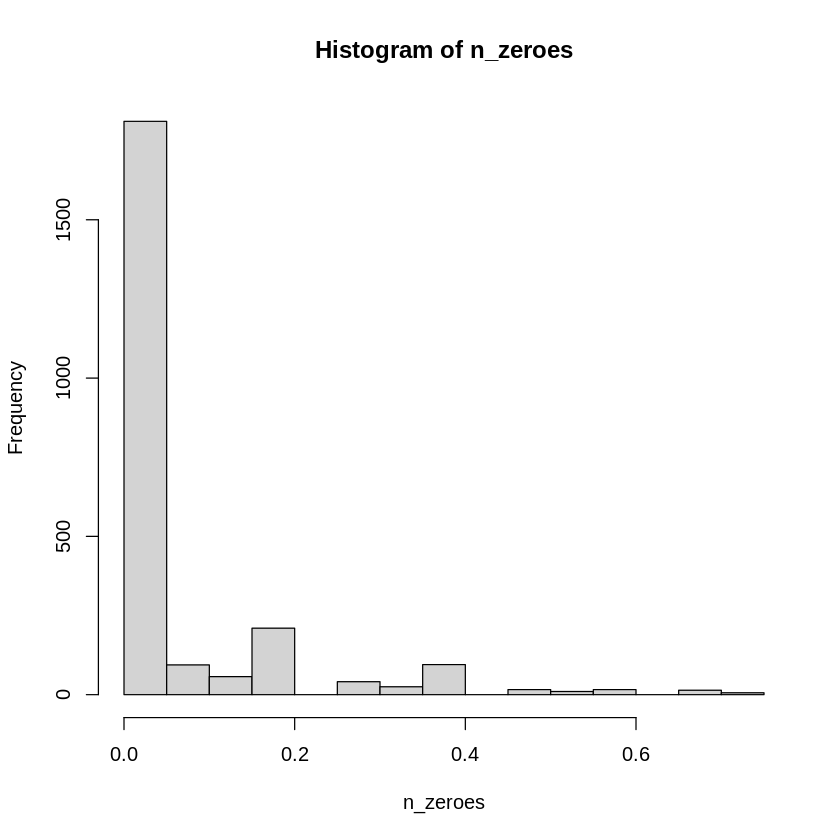

In [201]:
hist(n_zeroes)

Calculate the sparsity of the dataset (i.e how large proportion of the dataset that consist of missing values)

In [202]:
sum(ft==1267)/(nrow(ft)*ncol(ft))

[1] 0.07790536

Calculate how many metabolites have measurements (non 1267) in at least 50 % of the samples

In [203]:
dim(ft[,n_zeroes<0.5])

[1]   12 2349

Deselect metabolites with more than 50 % missing values. This helps to get rid of features that are present in too few samples to conduct proper statistical tests

In [204]:
ft <- ft[,n_zeroes<0.5]

Merge feature table and metadata to one dataframe

In [205]:
Data <- cbind.data.frame(md,ft)

In [206]:
dim(Data)

[1]   12 2353

##**Statistical Analysis**

**Run ANOVA**

We now use the function [aov](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/aov) to run the ANOVA. Since one ANOVA is being run for each metabolite feature, we run the analyses in a loop and save the output for each feature in a list called *anova_out*.

The vector *a* indicates which columns in the dataset are features (i.e. from column 5 to the last column of the data frame).

We can run a *for loop* to pass each feature column into the first argument of the *aov* function, while the second argument, *time point*, is constant.

In [207]:
anova_out=NULL
a <- 5:ncol(Data)
for (i in 1:length(a)){
  anova_out[[i]] <- aov(scale(Data[,a[i]])~as.factor(Data$'ATTRIBUTE_Time-Point'))
}

Visualize the first entry in the list - corresponding to the first feature in the table. Is there a statistically significant difference between the time points?

In [208]:
summary(anova_out[[1]])

                                       Df Sum Sq Mean Sq F value Pr(>F)
as.factor(Data$"ATTRIBUTE_Time-Point")  3  1.435  0.4783     0.4  0.757
Residuals                               8  9.565  1.1956               

**Extract p- and F-values from anova output list**

Lists of ANOVA results are not convenient when summarizing our findings. We extract the desired data from the list and summarize this in a dataframe called *output_anova*

The following is of interest:

*Feature ID*

*p-value* for ANOVA

*p-value* after taking multiple tests into consideration

*F-value*

In [209]:
output_anova <- data.frame(colnames(Data[5:ncol(Data)]))
colnames(output_anova)[1] <- "Metabolites"
output_anova["p"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,5]})
output_anova["p_bonferroni"] <- p.adjust(output_anova$p,method="bonferroni")
output_anova["significant"] <- ifelse(output_anova$p_bonferroni<0.05,"Significant","Nonsignificant")
output_anova["F"] <- sapply(1:length(a),function(n){summary(anova_out[[n]])[[1]][1,4]})

Now we have created a dataframe with desired results from the ANOVA. We can sort the results after the p value, using [arrange](https://dplyr.tidyverse.org/reference/arrange.html), and select the top N rows using [slice_head](https://dplyr.tidyverse.org/reference/slice.html). These can be run as a sequence of operations using *pipes* (%>%). Are there any significant findings?

In [210]:
output_anova %>% arrange (p) %>% slice_head(n=20)

Metabolites,p,p_bonferroni,significant,F
<chr>,<dbl>,<dbl>,<chr>,<dbl>
4413_492.353_11.345,4.794067e-17,1.126126e-13,Significant,40136.187
4364_434.294_11.262,1.324286e-15,3.110747e-12,Significant,17505.547
2090_260.186_7.042,2.645506e-15,6.214294e-12,Significant,14724.148
4131_497.159_10.949,1.090293e-14,2.561098e-11,Significant,10333.199
5098_277.216_12.219,1.141232e-14,2.680755e-11,Significant,10215.877
1304_224.151_6.196,1.153093e-14,2.708615e-11,Significant,10189.499
361_290.124_3.607,1.162673e-14,2.731120e-11,Significant,10168.436
5711_391.287_12.789,2.451517e-14,5.758614e-11,Significant,8437.897
348_273.145_3.244,2.925455e-14,6.871893e-11,Significant,8073.052


**Plot ANOVA results**

We will use [ggplot](https://ggplot2.tidyverse.org/) to visualize results from the ANOVA, with log(F-values) on the x-axis and -log(p) on the y-axis. Features are colored after statistical significance after multiple test correction. Since there are large differences in the F- and P-values, it is easier to plot their log. 

We can also display the names of some of the top features in the plot. This easily gets very cluttered if we decide to display too many names, so starting at the top 5 could be a good idea. We can select these similarly to the cell above (pipes with *arrange* and *slice_head*). Using [geom_text_repel](https://rdrr.io/cran/ggrepel/man/geom_text_repel.html#:~:text=geom_text_repel%20adds%20text%20directly%20to,away%20from%20the%20data%20points.), you can make sure the labels are not overlapping)

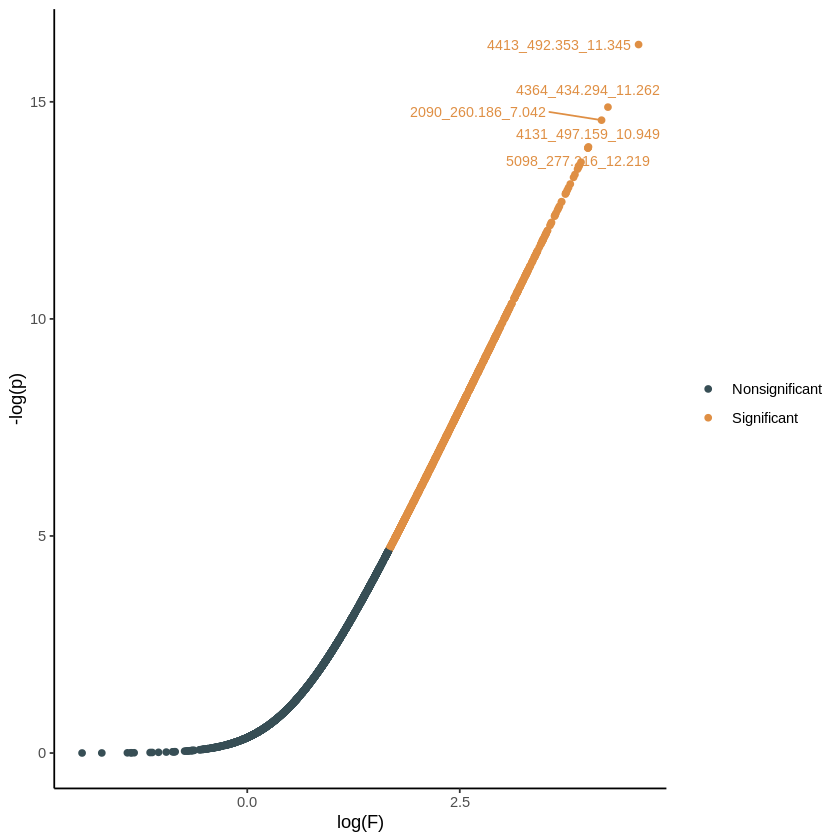

In [211]:
plot_anova <- ggplot(output_anova,aes(x=log(F,base=10),y=-log(p,base=10),color=significant))+ 
geom_point()+
theme_classic()+
scale_color_jama()+
ylab("-log(p)")+
xlab("log(F)")+
geom_text_repel(data=output_anova %>% arrange(p) %>% slice_head(n=5),
                  aes(label=Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)+
theme(legend.title = element_blank())

plot_anova

If you want, you can also export the plots to a pdf

In [212]:
pdf("plot_ANOVA.pdf")
plot_anova
dev.off()

png 
  2

Or maybe you want to export your results as a csv file

In [213]:
write.csv(output_anova,"ANOVA_results.csv")

**Calculate change from baseline and plot dilution series**

Since ANOVA only investigates the difference in variance between and within groups, additional tests are needed to test for differences between individual time points. By selecting features that were significant in the ANOVA, we can plot the temporal trends and select individual time points that we are interested in comparing. 

To simplify, we calculate the median value for each significant feature at each time point. By using [group_by](https://dplyr.tidyverse.org/reference/group_by.html) we group the rows by *timepoint* and [summarize_all](https://dplyr.tidyverse.org/reference/summarise_all.html) will calculate the median for each *feature* and *timepoint*

At this time we are interested in the features that actually change significantly with time. For this purpose we select features with "Significant" in the *significant* column in *anova_out*. This can be done using *%in%* and [subset](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/subset).

We also can divide the table according to the direction of the time trend for the features.

In [214]:
# Calculate medians for each year
timecourse_data <- Data[,5:ncol(Data)] %>% group_by(Data$'ATTRIBUTE_Time-Point') %>% summarize_all(.funs = median) 
# select only metabolites that were significant according to ANOVA
timecourse_data <- timecourse_data[,names(timecourse_data) %in% subset(output_anova,significant=="Significant")$Metabolites]

In [215]:
# Classify metabolites as increasing or decreasing with time
direction_pos <- sapply(1:ncol(timecourse_data),function(n){ifelse(timecourse_data[1,n]-timecourse_data[4,n]<0,TRUE,FALSE)})
timecourse_pos <- scale(timecourse_data[direction_pos])
timecourse_neg <- scale(timecourse_data[!direction_pos])

In [216]:
timecourse_neg[1:4,1:4]
dim(timecourse_neg)
timecourse_pos[1:4,1:4]
dim(timecourse_pos)

3501_158.154_9.708,2986_163.039_8.423,3869_163.148_10.547,3867_172.17_10.548
0.1879197,-0.4459272,0.3205472,0.2839697
0.2817336,-0.1708353,0.2490997,0.4627250
0.9431006,1.4445516,0.8712367,0.7281222
-1.4127539,-0.8277892,-1.4408836,-1.4748169


[1]   4 177

685_153.139_5.391,1532_162.055_6.418,5594_163.039_12.677,4362_163.039_11.261
-0.73382368,-0.6815077,-0.6139200,-0.4915074
-0.61318259,-0.5406600,-0.5775488,-0.5800252
-0.09405694,-0.2538980,-0.2930120,-0.4254569
1.44106322,1.4760657,1.4844809,1.4969895


[1]   4 704

Calculate the average for each feature and time point, in order to be able to plot the trends. Error bars can be visualized by calculating the standard deviation at each time point. By subtracting time=0 from each average, we get the change in feature level. 

In [217]:
timecourse_pos_summary <- cbind.data.frame(rep(c(0,5,15,45)),rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1],
                                   rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1]+rowSds(as.matrix(timecourse_pos)),
                                   rowMeans(timecourse_pos)-rowMeans(timecourse_pos)[1]-rowSds(as.matrix(timecourse_pos)),
                                   rep("pos",nrow(timecourse_pos)))
colnames(timecourse_pos_summary) <- c("time","median","high","low","direction")

timecourse_neg_summary <- cbind.data.frame(rep(c(0,5,15,45)),rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1],
                                   rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1]+rowSds(as.matrix(timecourse_neg)),
                                   rowMeans(timecourse_neg)-rowMeans(timecourse_neg)[1]-rowSds(as.matrix(timecourse_neg)),
                                   rep("neg",nrow(timecourse_neg)))
colnames(timecourse_neg_summary) <- c("time","median","high","low","direction")
# Combine increasing and decreasing features to dataframe for plotting
timecourse_summary <- rbind(timecourse_pos_summary,timecourse_neg_summary)

Plot temporal trends in ggplot

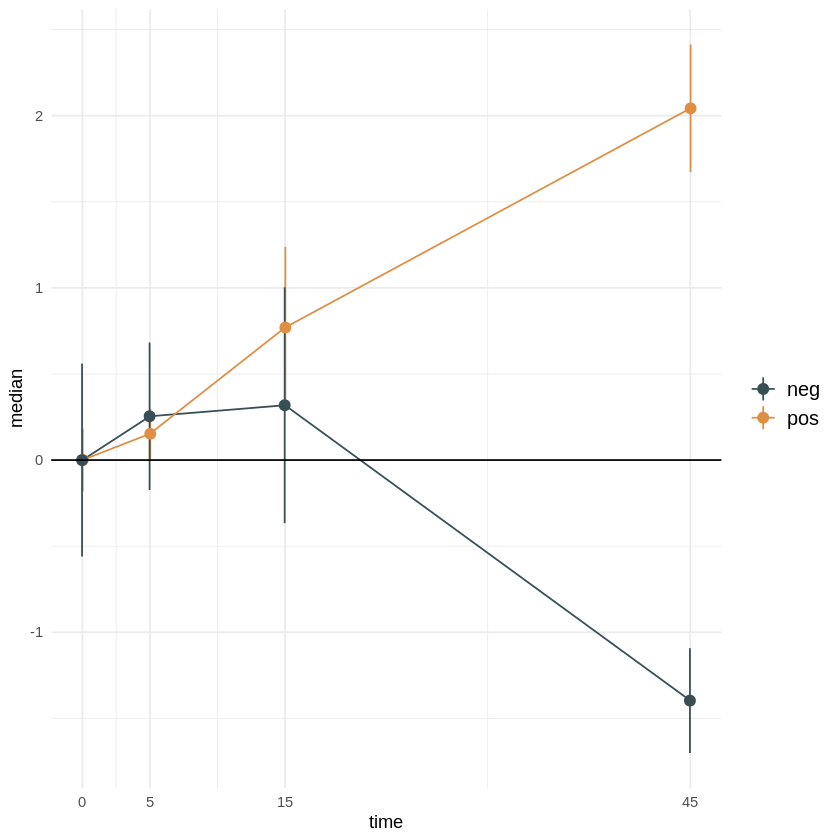

In [218]:
timecourse_plot <- ggplot(timecourse_summary,aes(x=time,y=median,max=high,min=low,color=direction,fill=direction))+
  geom_line()+
  geom_pointrange(position=position_dodge(0.1))+
  theme_minimal()+
  theme(legend.title = element_blank())+
  geom_hline(aes(yintercept=0))+
  scale_color_jama()+
  scale_fill_jama()+
  scale_x_continuous(breaks=c(0,5,15,45))+
  xlab("time")+
  theme(legend.text=element_text(size=12))

timecourse_plot

**Tukey's post hoc test**

Features with both positive and negative time trends exist, but differences appear to the largest between timepoint 0 and 45. Tukey's post hoc test can be used to calculate which features show statistically significant differences between these two timepoints. 

The function [TukeyHSD](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/TukeyHSD) is used, which calculate these differences from the ANOVA output list previously generated. Results are stored in a new list called *tukey_out*

In [219]:
tukey_out=NULL
for (i in 1:length(a)){
tukey_out[[i]] <- TukeyHSD(anova_out[[i]])
}

Display first entry of the list to show that all group wise differences are calculated. We are interested in the differences between timepoint 0 and 45.

In [220]:
tukey_out[[1]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`

,diff,lwr,upr,p adj
5-0,-0.7395758,-3.598614,2.119462,0.8397465
15-0,0.1803498,-2.678688,3.039388,0.9968383
45-0,-0.2506343,-3.109673,2.608404,0.9916767
15-5,0.9199257,-1.939113,3.778964,0.7375446
45-5,0.4889415,-2.370097,3.347980,0.9446074
45-15,-0.4309841,-3.290022,2.428054,0.9608084


We extract the information we are interested in from *tukey_out*. 

* diff - Difference in average levels between *timepoint* 0 and 45.

* p - p-value for group-wise difference after taking multiple group-wise comparisons into account.

* p_bonferroni - adjusted p-value after taking multiple tests (N number of features) into account

* significant - Whether the corrected p-value is below 0.05

In [221]:
output_tukey <- data.frame(colnames(Data[5:ncol(Data)]))
colnames(output_tukey)[1] <- "Metabolites"
output_tukey$ID <- as.numeric(as.character(lapply(strsplit(colnames(ft), "_"), function(l) l[[1]])))
output_tukey["diff"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`[3,1]})
output_tukey["p"] <- sapply(1:length(a),function(n){tukey_out[[n]]$`as.factor(Data$"ATTRIBUTE_Time-Point")`[3,4]})
output_tukey["p_bonferroni"] <- p.adjust(output_tukey$p,method="bonferroni")
output_tukey["significant"] <- ifelse(output_tukey$p_bonferroni<0.05,"Significant","Nonsignificant")
colnames(output_tukey) <- paste0("stats_",colnames(output_tukey))

Display the top results. Any significant hits? Other impressions?

In [222]:
output_tukey %>% arrange(stats_p) %>% slice_head(n=20)

stats_Metabolites,stats_ID,stats_diff,stats_p,stats_p_bonferroni,stats_significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1304_224.151_6.196,1304,2.239982,5.162537e-14,1.21268e-10,Significant
2090_260.186_7.042,2090,2.367443,5.162537e-14,1.21268e-10,Significant
348_273.145_3.244,348,2.354191,5.162537e-14,1.21268e-10,Significant
2038_276.134_7,2038,2.225034,5.162537e-14,1.21268e-10,Significant
361_290.124_3.607,361,2.374715,5.162537e-14,1.21268e-10,Significant
5508_307.227_12.587,5508,2.369146,5.162537e-14,1.21268e-10,Significant
365_319.15_3.788,365,2.220778,5.162537e-14,1.21268e-10,Significant
5218_319.191_12.346,5218,2.337166,5.162537e-14,1.21268e-10,Significant
3843_325.164_10.535,3843,2.292635,5.162537e-14,1.21268e-10,Significant


Create a *volcano plot* that displays -log(p) on the y-axis and group-difference on the x-axis. Again, display names of top findings in the plot

In [223]:
plot_tukey <- ggplot(output_tukey,aes(x=stats_diff,y=-log(stats_p,base=10),color=stats_significant))+ 
geom_point()+
theme_minimal()+
scale_color_jama()+
ylab("-log(p)")+
geom_text_repel(data=output_tukey %>% arrange(stats_p) %>% slice_head(n=5),
                  aes(label=stats_Metabolites),size=3,show.legend = FALSE,max.overlaps = 100)+
theme(legend.title = element_blank())


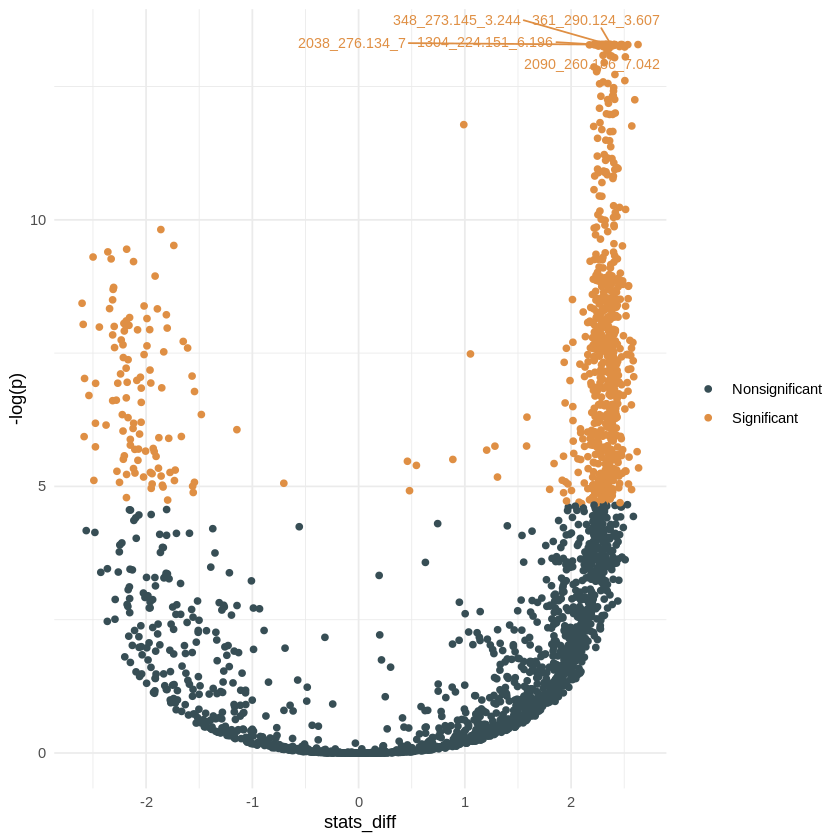

In [224]:
plot_tukey

Export plot as pdf

In [225]:
pdf("TukeyHSD_group0vsgroup45.pdf")
plot_tukey
dev.off()

png 
  2

Export results as csv

In [226]:
write.csv(output_tukey,"TukeyHSD_output.csv")

As a sanity check we can check a few of the top metabolites by plotting them in a boxplot. Just change the input argument for *y* to match a name in the result list above.

Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"1304_224.151_6.196"` is discouraged. Use `1304_224.151_6.196` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”
Warning message:
“Use of `Data$"1304_224.151_6.196"` is discouraged. Use `1304_224.151_6.196` instead.”
Warning message:
“Use of `Data$"ATTRIBUTE_Time-Point"` is discouraged. Use `ATTRIBUTE_Time-Point` instead.”


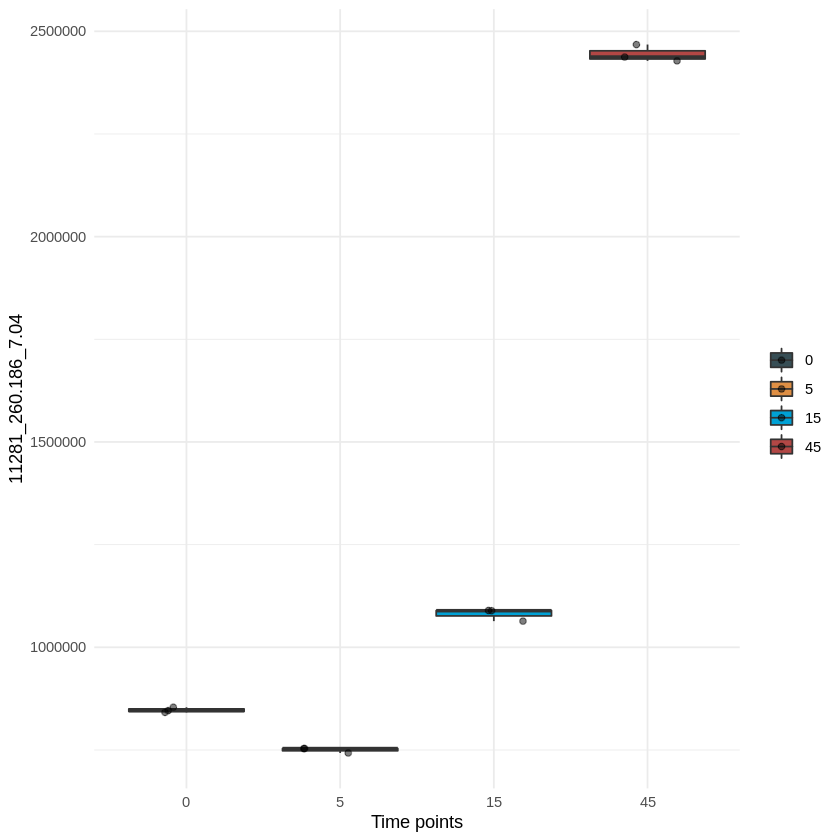

In [227]:
ggplot(Data,aes(x=as.factor(Data$'ATTRIBUTE_Time-Point'),y=Data$'1304_224.151_6.196',fill=as.factor(Data$'ATTRIBUTE_Time-Point')))+
geom_boxplot()+
geom_jitter(width=0.25, alpha=0.5)+
theme_minimal()+
scale_fill_jama()+
theme(legend.title = element_blank())+
xlab("Time points")+
ylab("11281_260.186_7.04")

In [228]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.1      matrixStats_0.62.0 ggsci_2.9          forcats_0.5.1     
 [5] stringr_1.4.0      dplyr_1.0.9        purrr_0.3.4        readr_2.1.2       
 [9] tidyr_1.2.0        tibble_3.1.7       ggplot2_3.3.6      tidyverse_1.3.2   

loaded via a namespace (an